Тестирование gradcam

In [52]:
import numpy as np
import gc
import torch
from  torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms.functional import gaussian_blur
from torchvision.transforms.v2 import RandomResizedCrop
import matplotlib.pyplot as plt
data = np.load("/home/n.yakovlev/datasets/test_files_WSS2.npz")
images = data["images"]
labels = data["labels"]
valid_images_num = labels.shape[0]
del data
gc.collect()
valid_dataset = TensorDataset(torch.tensor(images), torch.tensor(labels))
#del images, labels
valid_loader = DataLoader(valid_dataset, batch_size=128, num_workers=8)

In [34]:
from PIL import Image

In [53]:
image = torch.from_numpy(images[1])
image.size()

torch.Size([224, 224, 3])

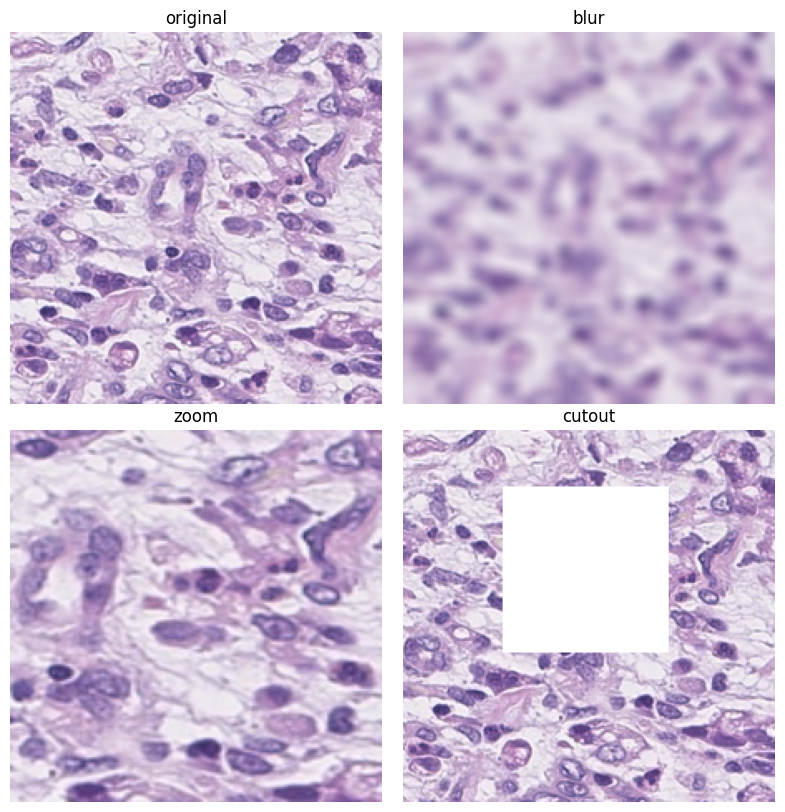

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.07)
plt.subplots_adjust(wspace=0.03)
ax[0][0].set_title("original")
ax[0][0].imshow(image)
for i in range(2):
    for j in range(2):
        ax[i][j].axis("off")
g_b = torchvision.transforms.v2.GaussianBlur((11, 11), (4., 4.))
image_temp = g_b(image.permute(2, 0, 1)).permute(1, 2, 0)
ax[0][1].set_title("blur")
ax[0][1].imshow(image_temp)
rrc = RandomResizedCrop((224, 224), (0.3, 0.4))
image_temp = rrc(image.permute(2, 0, 1)).permute(1, 2, 0)
ax[1][0].set_title("zoom")
ax[1][0].imshow(image_temp)
image_temp = image
image_temp[34:134, 60:160] = 1
ax[1][1].set_title("cutout")
ax[1][1].imshow(image_temp)
plt.show()

In [2]:
for batch in valid_loader:
    image = batch[0][:1].permute(0, 3, 1, 2)
    label = batch[1][1]
    break

In [4]:
label

tensor([0., 0., 0., 0., 1.])

In [5]:
device = "cuda:0"
path_to_checkpoint = "/home/n.yakovlev/my_best_program/diplom_8sem/experiments/exp_for_diplom_final/exp_with_class_with_pl/3_pl_in_one_image/checkpoints/best_valid_acc_85.pth"

In [6]:
from efficientnet_pytorch import EfficientNet
my_model = EfficientNet.from_name("efficientnet-b4", num_classes=5)
pretrained_dict = torch.load(path_to_checkpoint)
my_model.load_state_dict(pretrained_dict)
my_model = my_model.to(device)
my_model.eval()
my_model._fc

Linear(in_features=1792, out_features=5, bias=True)

In [7]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [my_model._fc]
input_tensor = image #Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAMPlusPlus(model=my_model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image[0], grayscale_cam, use_rgb=True)

# You can also get the model outputs without having to re-inference
model_outputs = cam.outputs

AxisError: axis 2 is out of bounds for array of dimension 2

In [10]:
model.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [9]:
for layer in model.children():
    print(layer)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [8]:
def get_layers(model: torch.nn.Module):
    children = list(model.children())
    return [model] if len(children) == 0 else [ci for c in children for ci in get_layers(c)]

l = get_layers(model)
for i, layer in enumerate(l):
    print(i, layer)

0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU(inplace=True)
3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4 Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
5 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
6 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
7 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
8 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
9 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
10 ReLU(inplace=True)
11 Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
12 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
13 Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
14 BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

Копирование части весов

In [ ]:
# copy parts of layer weights
pretrained_dict = torch.load("/home/n.yakovlev/my_best_program/diplom_8sem/checkpoint_dump/checkpoint_epoch60.pth")
model_dict = model.state_dict()

processed_dict = {}

for k in model_dict.keys():
    decomposed_key = k.split(".")
    if ("model" in decomposed_key):
        pretrained_key = ".".join(decomposed_key[1:])
        processed_dict[k] = pretrained_dict[pretrained_key]

model.load_state_dict(processed_dict, strict=False)

Сохранение случайного поднабора данных

In [ ]:
from pathlib import Path
PATCH_SIZE = 224
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import time
from psimodels_main.datasets.psi_dataset_regions_cls import (
    PSIRegionClsDataset,
    PSIRegionClsDatasetParams,
)
from datasets.psi_torch_dataset import TorchPSIDataset
import random
def low_entropy_filter_with_prob(patch_size: int, skip_prob: float = 1):
    def low_entropy(item) -> bool:
        patch_src, patch_dst = item
        p = np.mean(patch_src, axis=2).flatten()
        entropy = -np.sum(p * np.log2(p + 0.001)) / (patch_size * patch_size)
        if entropy > 0.2 or random.random() < skip_prob:
            return True
        return False

    return low_entropy

train_ds = TorchPSIDataset(
    ds_constructor=PSIRegionClsDataset,
    ds_params=PSIRegionClsDatasetParams(
        path=Path("/home/n.yakovlev/datasets/symblink/WSS2/train_valid/"),
        patch_size=PATCH_SIZE,
        layer=2,
        region_intersection=0.7,
        n_patches_from_one_region=1,
        balance_coeff=0.3
    ),
    n_procs=32,
    queue_size=300
)
batch_size = 128
dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
data_iterator = iter(dataloader)
iterations_per_epoch = 100
patches = []
patches_classes = []
np.random.seed(time.time_ns() % 2**32)
for _ in tqdm(
    range(iterations_per_epoch), f"running epoch"
):
    np.random.seed(time.time_ns() % 2**32)
    inputs, labels = next(data_iterator)
    for i in range(20):
        print(inputs[i].mean(), labels[i].argmax(), sep=" ", end="\t")
    print()
    patches.append(inputs)
    patches_classes.append(labels)
patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
patches_classes = np.array(patches_classes).reshape(-1, 5)

In [2]:
np.unique(patches_classes.argmax(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4]), array([2493, 2568, 2539, 2604, 2596]))

In [3]:
patches.shape

(12800, 224, 224, 3)

In [3]:
np.savez(file="/home/n.yakovlev/datasets/train_valid_files_WSS2.npz", images=patches, labels=patches_classes)

Создание dense патчей для обучения сети

In [ ]:
import torch
import numpy as np
from efficientnet_pytorch import EfficientNet
import torch.utils.data as data
import gc
import matplotlib.pyplot as plt
import IPython
from PIL import Image

import json
from pathlib import Path
import os
import numpy as np
from shapely.geometry import Polygon
from psimage import PSImage

ds_path = Path("/home/n.yakovlev/datasets/symblink/WSS2/train_valid")
file_names = list(set([name_parts[:13] for name_parts in os.listdir(ds_path)]))
anno_classes = set()
for file_name in file_names:
    anno_json = open(ds_path / Path(file_name + ".json"), "r")
    for k, anno in enumerate(json.load(anno_json)):
        anno_cls = anno["class"]
        anno_classes.add(anno_cls)
anno_classes = sorted(list(anno_classes))
print("anno_classes:", anno_classes)
os.makedirs(f"/home/n.yakovlev/datasets/train_patches_from_PATH_DT_MSU", exist_ok=True)
for i, anno_class in enumerate(anno_classes):
    os.makedirs(f"/home/n.yakovlev/datasets/train_patches_from_PATH_DT_MSU/{i}", exist_ok=True)

global_index = {k: 0 for k in anno_classes}

patches = None
labels = None

for file_ind, file_name in enumerate(file_names):
    psim = PSImage(ds_path / f"{file_name}.psi")
    anno_json = open(ds_path / f"{file_name}.json")
    loaded_json = json.load(anno_json)
    for k, anno in enumerate(loaded_json):
        anno_cls = anno["class"]
        anno_cls_ind = -1
        for i in range(len(anno_classes)):
            if anno_cls == anno_classes[i]:
                anno_cls_ind = i
                break
        anno_polygon = np.array(anno["vertices"], dtype=np.float64)
        anno_polygon[anno_polygon < 0] = 0
        print(f"processing region {k + 1} ({anno_cls})")
        out_path = Path(f"/home/n.yakovlev/datasets/train_patches_from_PATH_DT_MSU/{anno_cls_ind}")
        # example of dense patch extraction from each annotated region
        polygon = Polygon(anno_polygon)
        if polygon.area < 224 * 224 * 0.7:
            continue
        for i, patch in enumerate(
            psim.patch_gen_dense(224, stride=300, layer=2, region=anno_polygon)
        ):
            img = Image.fromarray((patch.data * 255).astype(np.uint8), mode="RGB")
            img.save(out_path / f"{global_index[anno_cls]}.jpeg")
            global_index[anno_cls] += 1
            
        print("global index:", global_index)

    print("All patches extracted.")
    anno_json.close()
    psim.close()

Работа с аугментациями

In [1]:
from pathlib import Path
PATCH_SIZE = 224
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import time
from psimodels_main.datasets.psi_dataset_regions_cls import (
    PSIRegionClsDataset,
    PSIRegionClsDatasetParams,
)
from datasets.psi_torch_dataset import TorchPSIDataset
import matplotlib.pyplot as plt
import random
def low_entropy_filter_with_prob(patch_size: int, skip_prob: float = 1):
    def low_entropy(item) -> bool:
        patch_src, patch_dst = item
        p = np.mean(patch_src, axis=2).flatten()
        entropy = -np.sum(p * np.log2(p + 0.001)) / (patch_size * patch_size)
        if entropy > 0.2 or random.random() < skip_prob:
            return True
        return False

    return low_entropy

train_ds = TorchPSIDataset(
    ds_constructor=PSIRegionClsDataset,
    ds_params=PSIRegionClsDatasetParams(
        path=Path("/home/n.yakovlev/datasets/symblink/WSS2/train/"),
        patch_size=PATCH_SIZE,
        layer=2,
        region_intersection=0.7,
        n_patches_from_one_region=1,
    ),
    n_procs=2,
    queue_size=300,
    filter=low_entropy_filter_with_prob(PATCH_SIZE),
)
batch_size = 128
dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
data_iterator = iter(dataloader)
iterations_per_epoch = 1
np.random.seed(time.time_ns() % 2**32)
for _ in tqdm(range(iterations_per_epoch), f"running epoch"):
    np.random.seed(time.time_ns() % 2**32)
    inputs, labels = next(data_iterator)
    print(inputs.max(), inputs.mean())

ModuleNotFoundError: No module named 'psimodels_main.datasets'

In [2]:
from common_utils.RandAugment import RandAugment
import torchvision
rand_aug = RandAugment(2, 16, 31)

In [ ]:
for i, (image, label) in enumerate(zip(inputs, labels)):
    print(i, label)
    fig, ax = plt.subplots(ncols=2, figsize=(5, 2.3))
    fig.subplots_adjust(wspace=0.03, hspace=0.03)
    img = (image * 255).to(torch.uint8).permute(2, 0, 1)
    img = torchvision.transforms.ToPILImage()(img)
    augmented_image = rand_aug(img, True)
    augmented_image = torchvision.transforms.functional.pil_to_tensor(augmented_image).permute(1, 2, 0)
    print(augmented_image.size())
    ax[0].axis('off')
    ax[1].axis("off")
    ax[0].imshow(np.array(img)[..., [2, 1, 0]])
    ax[1].imshow(np.array(augmented_image)[..., [2, 1, 0]])
    plt.show()
    plt.close()
    if i > 50:
        break

Предсказание на тестовой выборке с использованием случайных патчей

In [ ]:
from pathlib import Path
PATCH_SIZE = 224
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import time
from psimodels_main.datasets.psi_dataset_regions_cls import (
    PSIRegionClsDataset,
    PSIRegionClsDatasetParams,
)
from datasets.psi_torch_dataset import TorchPSIDataset
import random
def low_entropy_filter_with_prob(patch_size: int, skip_prob: float = 1):
    def low_entropy(item) -> bool:
        patch_src, patch_dst = item
        p = np.mean(patch_src, axis=2).flatten()
        entropy = -np.sum(p * np.log2(p + 0.001)) / (patch_size * patch_size)
        if entropy > 0.2 or random.random() < skip_prob:
            return True
        return False

    return low_entropy

train_ds = TorchPSIDataset(
    ds_constructor=PSIRegionClsDataset,
    ds_params=PSIRegionClsDatasetParams(
        path=Path("/home/n.yakovlev/datasets/symblink/WSS2/train_valid/"),
        patch_size=PATCH_SIZE,
        layer=2,
        region_intersection=0.7,
        n_patches_from_one_region=1,
    ),
    n_procs=32,
    queue_size=300
)
batch_size = 128
dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
data_iterator = iter(dataloader)
iterations_per_epoch = 100
patches = []
patches_classes = []
np.random.seed(time.time_ns() % 2**32)
for _ in tqdm(
    range(iterations_per_epoch), f"running epoch"
):
    np.random.seed(time.time_ns() % 2**32)
    inputs, labels = next(data_iterator)
    for i in range(20):
        print(inputs[i].mean(), labels[i].argmax(), sep=" ", end="\t")
    print()
    patches.append(inputs)
    patches_classes.append(labels)
patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
patches_classes = np.array(patches_classes).reshape(-1, 5)

Тестирование dense геенратора

In [3]:
from nets_parts.datasets.psi_dataset_regions_cls import (
    PSIRegionClsDenseDataset,
    PSIRegionClsDenseDatasetParams,
)
from pathlib import Path
import IPython
import numpy as np
import torch
from torch.utils.data import DataLoader
from nets_parts.datasets.psi_torch_dataset import TorchPSIDenseDataset
import random
import torch
import numpy as np
from efficientnet_pytorch import EfficientNet
import gc
import IPython
from psimage.base.exceptions import PSImageException
from psimage.base.patch_generators import PatchGenerator
from psimage.image import PSImage
from nets_parts.datasets.psi_dataset_regions_cls import RegionAnnotation
import json
import glob

['/home/n.yakovlev/anaconda3/envs/torch_c11/lib/python312.zip', '/home/n.yakovlev/anaconda3/envs/torch_c11/lib/python3.12', '/home/n.yakovlev/anaconda3/envs/torch_c11/lib/python3.12/lib-dynload', '', '/home/n.yakovlev/anaconda3/envs/torch_c11/lib/python3.12/site-packages', '/home/n.yakovlev/my_best_program/diplom_8sem/nets_parts/datasets']
psimage tile cache size was set up to 300 tiles


In [2]:
PATCH_SIZE = 224
LAYER = 2
REGION_INTERSECTION = 0.7

In [4]:
path = Path("/home/n.yakovlev/datasets/symblink/WSS2/test/")
anno_files = sorted(
    [
        f
        for f in path.iterdir()
        if f.is_file() and f.suffix == ".json"
    ]
)
psims = list()
regions: dict[str, PatchGenerator] = dict()
for anno_file in anno_files:
    # TODO in the future change file name to the canonical version!
    file_name = anno_file.stem
    psim = PSImage(path / f"{file_name}.psi")
    psims.append(psim)
    with open(anno_file) as f:
        for i, a in enumerate(json.load(f)):
            cls = a["class"]
            vertices = np.array(a["vertices"], dtype=np.float64)
            try:
                random_generator = psim.patch_gen_dense(
                    patch_size=PATCH_SIZE,
                    stride=PATCH_SIZE // 2,
                    layer=LAYER,
                    region=vertices,
                    region_intersection=REGION_INTERSECTION
                )
                region = RegionAnnotation(
                    file_name=file_name,
                    region_idx=i,
                    class_=cls,
                    vertices=vertices,
                    random_generator=random_generator,
                )
                if cls not in regions:
                    regions[cls] = [region]
                else:
                    regions[cls].append(region)
            except PSImageException:
                continue

In [5]:
regions.keys()

dict_keys(['AT', 'BG', 'LP', 'MM', 'TUM'])

In [6]:
res = 0
for reg in regions.values():
    res += len(reg)
print(res)

442


In [7]:
def low_entropy_filter_with_prob(patch_size: int, skip_prob: float = 1):
    def low_entropy(item) -> bool:
        patch_src, patch_dst = item
        p = np.mean(patch_src, axis=2).flatten()
        entropy = -np.sum(p * np.log2(p + 0.001)) / (patch_size * patch_size)
        if entropy > 0.2 or random.random() < skip_prob:
            return True
        return False

    return low_entropy

train_ds = TorchPSIDenseDataset(
    ds_constructor=PSIRegionClsDenseDataset,
    ds_params=PSIRegionClsDenseDatasetParams(
        path=Path("/home/n.yakovlev/datasets/symblink/WSS2/test/"),
        patch_size=PATCH_SIZE,
        layer=2,
        region_intersection=0.7,
        psims=psims,
        regions=regions,
        skip_bg=True
    ),
    n_procs=64,
    queue_size=300
)

Creating PSIDatasetParallel instance...
Reading annotation files...
Annotations for 5 classes found:
	 AT: area 1085.91M pixels (9.54%)
	 BG: area 8032.2M pixels (70.59%)
	 LP: area 317.62M pixels (2.79%)
	 MM: area 743.83M pixels (6.54%)
	 TUM: area 1198.62M pixels (10.53%)
	 all processes started


In [8]:
batch_size = 128
dataloader = DataLoader(train_ds, batch_size=batch_size, drop_last=False)

In [9]:
train_ds.__len__()

58739

In [10]:
paths_1 = glob.glob("/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/*/*/*.pth")
paths_3 = glob.glob("/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_PL_2/*/*/*.pth")
path_to_checkpoints = paths_1 + paths_3
title_for_checkpoint = []

In [11]:
for path in path_to_checkpoints:
    print(path)
    suffix = path.split('/')[-3][-13:]
    if "AE" in path:
        suffix = "AE+PL " + suffix
    else:
        suffix = "PL " + suffix
    print(suffix)
    title_for_checkpoint.append(suffix)

/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/21_firts_image_80/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_80
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/18_firts_image_60/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_60
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/13_firts_image_20/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_20
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/14_firts_image_20/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_20
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/20_firts_image_60/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_60
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/12_firts_image_20/checkpoints/best_valid_acc_best.pth
AE+PL irts_image_20
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_res

In [12]:
device = "cuda:0"
model_arr = []
for cur_path in path_to_checkpoints:
    print(cur_path)
    model = EfficientNet.from_name("efficientnet-b4", num_classes=5)
    pretrained_dict = torch.load(cur_path)
    model.load_state_dict(pretrained_dict)
    model = model.to(device)
    model_arr.append(model)
    model.eval()
    gc.collect()

/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/21_firts_image_80/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/18_firts_image_60/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/13_firts_image_20/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/14_firts_image_20/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/20_firts_image_60/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/12_firts_image_20/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/experiments_for_results/with_AE_PL_2/15_firts_image_40/checkpoints/best_valid_acc_best.pth
/home/n.yakovlev/my_best_program/diplom_8sem/exp

In [13]:
matrix_conf = np.zeros((len(path_to_checkpoints), 5, 5))
matrix_conf[:, 1, 1] = 1

In [16]:
def compute_confusion_matrix(true, pred):
    '''Computes a confusion matrix using numpy for two np.arrays
    true and pred.
    Results are identical (and similar in computation time) to:
      "from sklearn.metrics import confusion_matrix"
    However, this function avoids the dependency on sklearn.'''
    K = len(np.unique(true)) # Number of classes
    result = np.zeros((5, 5))
    for i in range(len(true)):
        result[int(true[i])][int(pred[i])] += 1
    return result

In [15]:
example_count = np.array([19861., 156135., 5674., 12387., 20565.])

In [17]:
with torch.no_grad():
    for iter_num, (patches, labels) in enumerate(dataloader):
        patches = patches.permute(0, 3, 1, 2)
        if patches.max() > 1.1:
            patches /= 255
        patches, labels = patches.to(device), labels.to(device)
        for i, model in enumerate(model_arr):
            model.eval()
            logits = model(patches)
            outputs = logits.argmax(dim=1).cpu().numpy()
            matrix_conf[i] += compute_confusion_matrix(labels.reshape(-1).cpu().numpy(), outputs)
            gc.collect()
            torch.cuda.empty_cache()
        if iter_num % 2 == 0:    
            IPython.display.clear_output()
            for i in range(len(model_arr)):
                matrix_conf_sum = matrix_conf[i].sum(axis=1, keepdims = True)
                matrix_norm = np.zeros((5, 5))
                np.divide(matrix_conf[i], matrix_conf_sum, where=matrix_conf_sum!=0, out=matrix_norm)
                print(title_for_checkpoint[i])
                print("Accuracy:", (example_count * matrix_norm.diagonal()).sum() / example_count.sum())
                print("Accuracy for classes:", matrix_norm.diagonal()) 
                print("Balanced accuracy:", matrix_norm.diagonal().sum() / matrix_norm.sum())
            """
            for i in range(len(model_arr)):
                fig, ax = plt.subplots()
                matrix_conf_sum = matrix_conf[i].sum(axis=1, keepdims = True)
                matrix_norm = np.zeros((5, 5))
                np.divide(matrix_conf[i], matrix_conf_sum, where=matrix_conf_sum!=0, out=matrix_norm)
                matrix_norm = np.round(matrix_norm, 3)
                res = ax.imshow(matrix_norm, cmap = plt.cm.jet, interpolation = 'nearest')
                
                # Annotate each cell with the corresponding value
                for k, j in np.ndindex(matrix_norm.shape):
                    ax.annotate(str(matrix_norm[k, j]), xy = (j, k), ha = 'center', va = 'center')


                # Customize x and y axis labels with strings
                alphabet = ["AT", "BG", "LP", "MM", "TUM"]
                plt.title(f"{title_for_checkpoint[i]}")
                plt.xticks(range(len(alphabet)), list(alphabet[: len(alphabet)]))
                plt.yticks(range(len(alphabet)), list(alphabet[: len(alphabet)]))
                plt.xlabel("predicted")
                plt.ylabel("GT")
                print(matrix_conf[i].sum(axis = 1, keepdims = True))
                # Show the plot
                plt.show()
            """

AE+PL irts_image_80
Accuracy: 0.9465535346365482
Accuracy for classes: [0.97265999 1.         0.77299965 0.80293856 0.64994956]
Balanced accuracy: 0.8397095519007196
AE+PL irts_image_60
Accuracy: 0.9357070829236154
Accuracy for classes: [0.97271034 1.         0.5306662  0.79914426 0.60585099]
Balanced accuracy: 0.7816743569699055
AE+PL irts_image_20
Accuracy: 0.9238144560317537
Accuracy for classes: [0.76169377 1.         0.33627071 0.87276984 0.69481674]
Balanced accuracy: 0.7331102111754553
AE+PL irts_image_20
Accuracy: 0.9274817447877263
Accuracy for classes: [0.94466542 1.         0.75132182 0.74981836 0.51592448]
Balanced accuracy: 0.7923460172552756
AE+PL irts_image_60
Accuracy: 0.9396878014064063
Accuracy for classes: [0.97875233 1.         0.69897779 0.69798983 0.65605034]
Balanced accuracy: 0.8063540587285892
AE+PL irts_image_20
Accuracy: 0.9316129928558214
Accuracy for classes: [0.91289462 1.         0.43056045 0.7930088  0.65220733]
Balanced accuracy: 0.7577342397736306
AE+P

In [19]:
import os
for cur_path in path_to_checkpoints:
    os.rename(cur_path, cur_path + "_checked")

PL five image 3
Accuracy: 0.9717262829776598
Accuracy for classes: [0.9658124  1.         0.93549524 0.92282231 0.80222895]
Balanced accuracy: 0.9252717797632665
PL five image 5
Accuracy: 0.9732437096708738
Accuracy for classes: [0.97150194 1.         0.94977088 0.93129894 0.80352596]
Balanced accuracy: 0.9312195460010984
PL five image 8
Accuracy: 0.9693053463932403
Accuracy for classes: [0.95851166 1.         0.94959464 0.90861387 0.78868233]
Balanced accuracy: 0.9210804989120963
PL five image 11
Accuracy: 0.9734254506872021
Accuracy for classes: [0.96243895 1.         0.93020797 0.8986841  0.83921795]
Balanced accuracy: 0.9261097936084196
PL five image 14
Accuracy: 0.9735582372568576
Accuracy for classes: [0.95508786 1.         0.90165668 0.91596028 0.84517462]
Balanced accuracy: 0.9235758876123701
PL five image 17
Accuracy: 0.9652474030866636
Accuracy for classes: [0.96294245 1.         0.97920338 0.92354888 0.72488831]
Balanced accuracy: 0.9181166056426271
[[1.9861e+04]
 [1.0000e+0

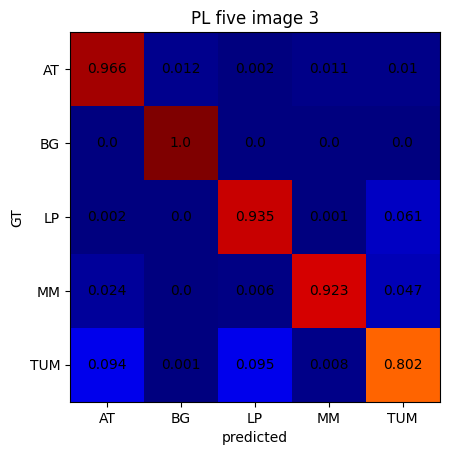

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


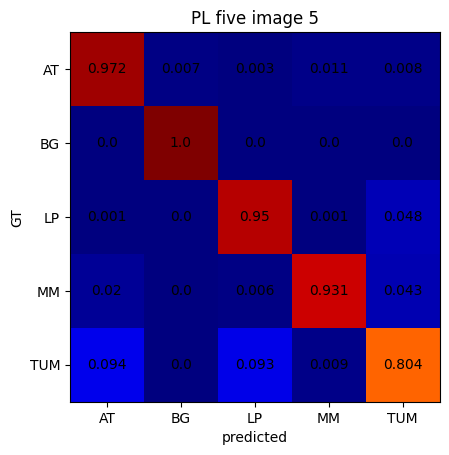

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


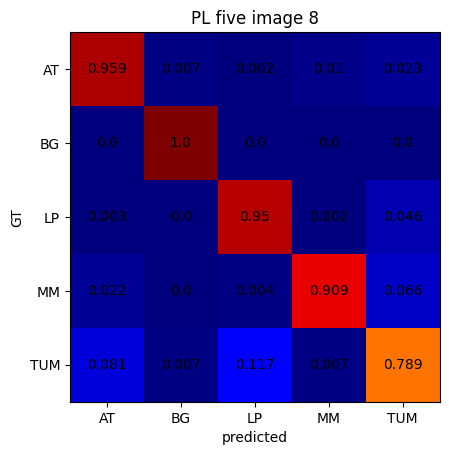

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


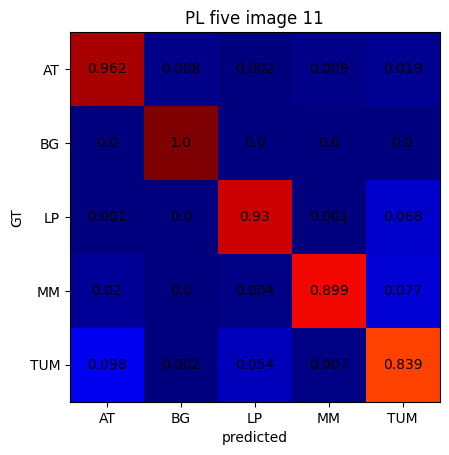

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


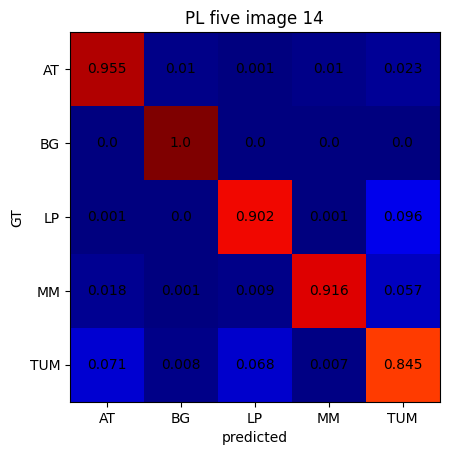

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


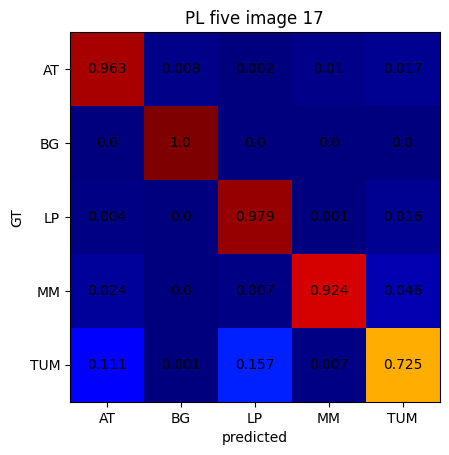

PL one image
Accuracy for classes: [0.91984291 1.         0.68840324 0.82295955 0.55762118]
Balanced accuracy: 0.7977653760893942
PL_autoencoder one image
Accuracy for classes: [0.88983435 1.         0.80437081 0.89739243 0.47581304]
Balanced accuracy: 0.8134821255860738
[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


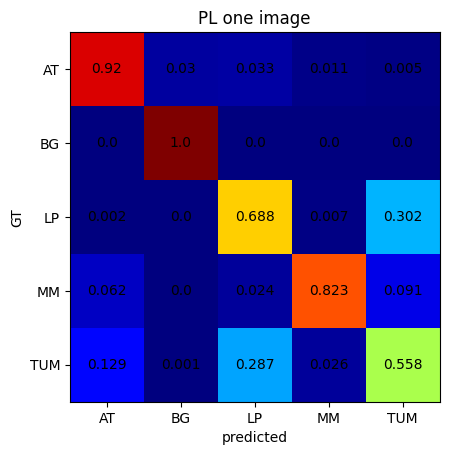

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


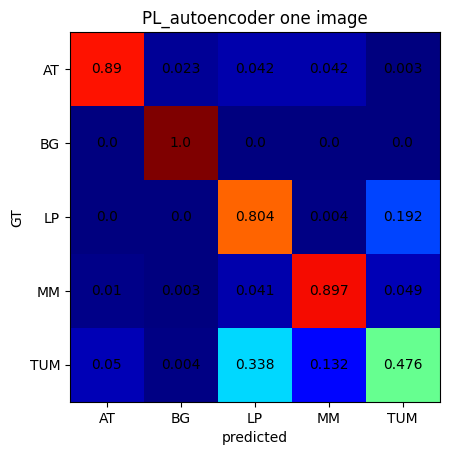

In [98]:
инфа о предыдущем прогоне

PL five image (5)
Accuracy for classes: [0.9617844  1.         0.95435319 0.93137967 0.8053514 ]
Balanced accuracy: 0.9305737318623146
PL five image (8)
Accuracy for classes: [0.95463471 1.         0.90729644 0.92750464 0.84032281]
Balanced accuracy: 0.9259517212386502
PL five image (9)
Accuracy for classes: [0.9633956  1.         0.94747973 0.9216921  0.80261325]
Balanced accuracy: 0.9270361353734424
PL five image (10)
Accuracy for classes: [0.95805851 1.         0.96316532 0.92064261 0.78680886]
Balanced accuracy: 0.925735057885389
[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


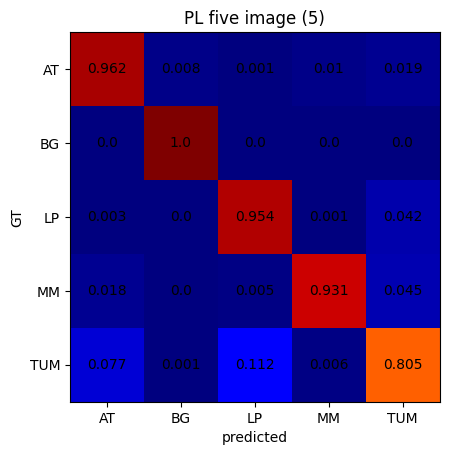

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


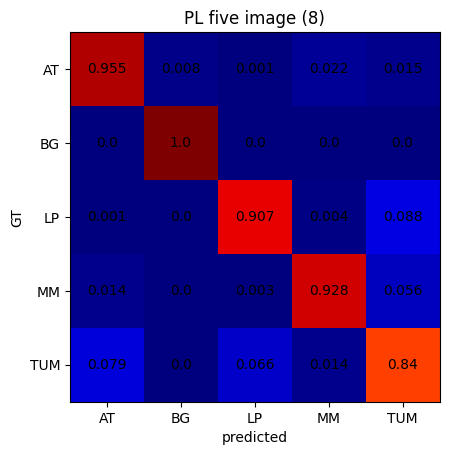

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


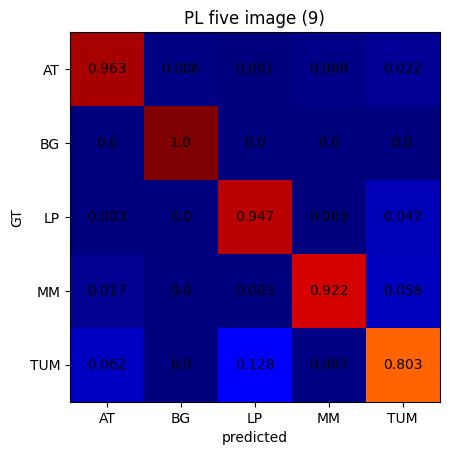

[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0817e+04]]


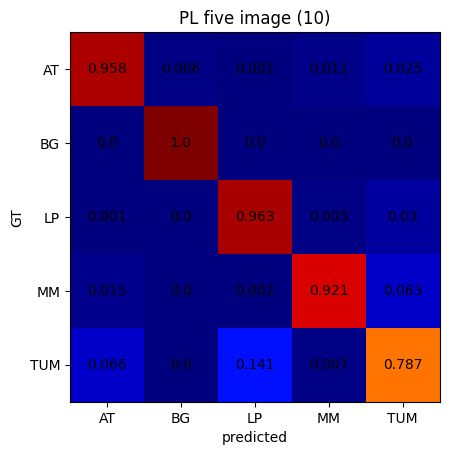

In [46]:
инфа о предыдущем прогоне

five image
Accuracy for classes: [0.96948794 1.         0.93496651 0.93638492 0.81204993]
Balanced accuracy: 0.9305778605553536
[[1.9861e+04]
 [1.0000e+00]
 [5.6740e+03]
 [1.2387e+04]
 [2.0830e+04]]


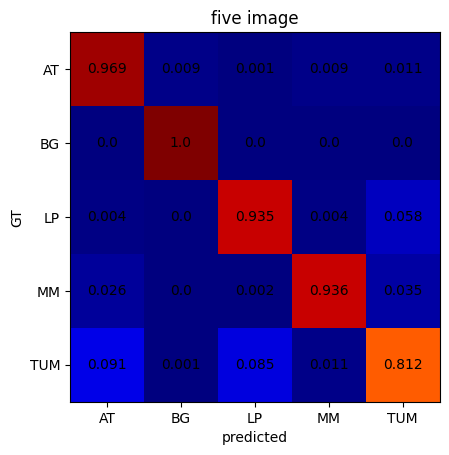

In [23]:
инфа о предыдущем прогоне

PL in one image
Accuracy for classes: [0.9715374  1.         0.74206494 0.86362523 0.71772418]
Balanced accuracy: 0.8589903519360551
PL in one image 20 %
Accuracy for classes: [0.93450429 1.         0.4483765  0.74651106 0.6157233 ]
Balanced accuracy: 0.749023029982133
PL in one image 60 %
Accuracy for classes: [0.96920961 1.         0.63608172 0.79409124 0.70456436]
Balanced accuracy: 0.8207893856720802
one image 20 %
Accuracy for classes: [0.90953338 1.         0.41535936 0.65184037 0.76459077]
Balanced accuracy: 0.7482647759359345
one image 60 %
Accuracy for classes: [0.97936726 1.         0.50875593 0.62751979 0.83415684]
Balanced accuracy: 0.789959964786029
[[1.8902e+04]
 [1.0000e+00]
 [5.4820e+03]
 [1.2253e+04]
 [2.0441e+04]]


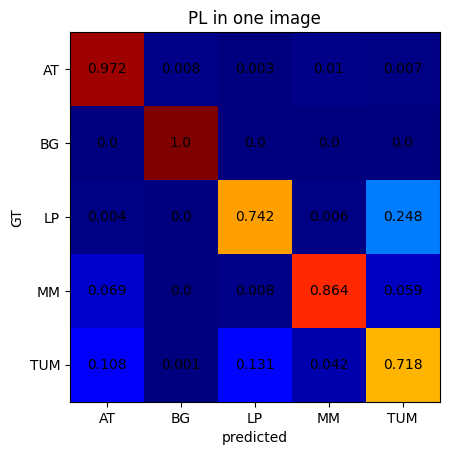

[[1.8902e+04]
 [1.0000e+00]
 [5.4820e+03]
 [1.2253e+04]
 [2.0441e+04]]


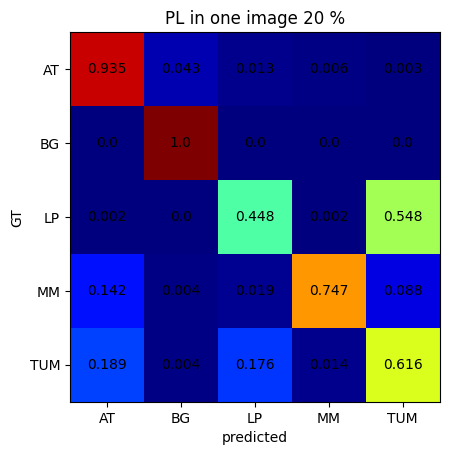

[[1.8902e+04]
 [1.0000e+00]
 [5.4820e+03]
 [1.2253e+04]
 [2.0441e+04]]


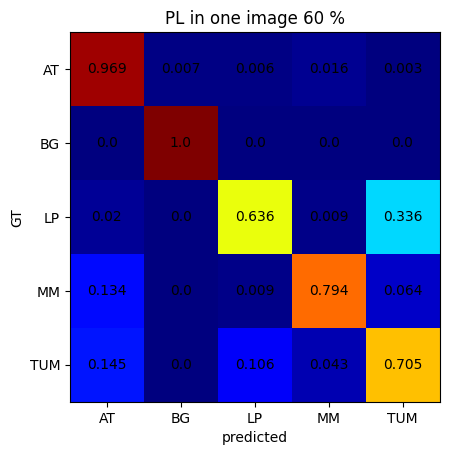

[[1.8902e+04]
 [1.0000e+00]
 [5.4820e+03]
 [1.2253e+04]
 [2.0441e+04]]


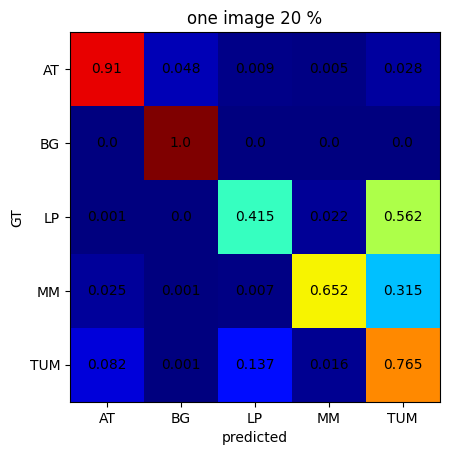

[[1.8902e+04]
 [1.0000e+00]
 [5.4820e+03]
 [1.2253e+04]
 [2.0441e+04]]


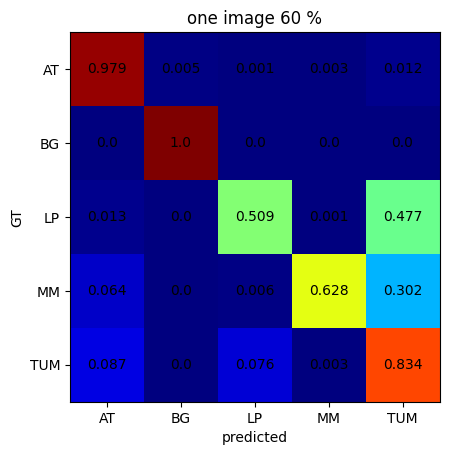

KeyboardInterrupt: 

In [33]:
инфа о предыдущем прогоне

GradCam

In [101]:
import cv2
import numpy as np
import torch
from torchvision.utils import make_grid, save_image
from torch.autograd import Function
from pathlib import Path
PATCH_SIZE = 224
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import time
from nets_parts.datasets.psi_dataset_regions_cls import (
    PSIRegionClsDataset,
    PSIRegionClsDatasetParams,
)
from nets_parts.datasets.psi_torch_dataset import TorchPSIDataset
import random
def low_entropy_filter_with_prob(patch_size: int, skip_prob: float = 1):
    def low_entropy(item) -> bool:
        patch_src, patch_dst = item
        p = np.mean(patch_src, axis=2).flatten()
        entropy = -np.sum(p * np.log2(p + 0.001)) / (patch_size * patch_size)
        if entropy > 0.2 or random.random() < skip_prob:
            return True
        return False

    return low_entropy

train_ds = TorchPSIDataset(
    ds_constructor=PSIRegionClsDataset,
    ds_params=PSIRegionClsDatasetParams(
        path=Path("/home/n.yakovlev/datasets/symblink/WSS2/test/"),
        patch_size=PATCH_SIZE,
        layer=2,
        region_intersection=0.7,
        n_patches_from_one_region=1,
        balance_coeff=0.3
    ),
    n_procs=32,
    queue_size=300
)
batch_size = 256
dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

Creating PSIDatasetParallel instance...
Reading annotation files...

Annotations for 5 classes found:	 AT: area 1085.91M pixels (9.54%)
	 BG: area 8032.2M pixels (70.59%)
	 LP: area 317.62M pixels (2.79%)
	 MM: area 743.83M pixels (6.54%)
	 TUM: area 1198.62M pixels (10.53%)
	 all processes started


In [102]:
classes_name = ["AT", "BG", "LP", "MM", "TUM"]

In [103]:
for batch in dataloader:
    a = 0
    break

In [104]:
batch[1]

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0

In [109]:
batch[1] = batch[1].argmax(1)

In [123]:
mask = (batch[1] == 2) + (batch[1] == 3) + (batch[1] == 4)

In [129]:
images = batch[0][mask]
labels = batch[1][mask]
images = images[:10].permute(0, 3, 1, 2)
labels = labels[:10]

In [130]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet

weights_paths = [
    "/home/n.yakovlev/my_best_program/diplom_8sem/experiments/final_class_diff_images_percent/0_20_percent_one_inage/checkpoints/best_valid_acc_74.pth",
    "/home/n.yakovlev/my_best_program/diplom_8sem/experiments/classifier_pl_different_image_percent/15_pl_20_percent_one_image/checkpoints/best_valid_acc_77.pth",
    "/home/n.yakovlev/my_best_program/diplom_8sem/experiments/final_class_pl_diff_precent_num/8/checkpoints/best_valid_acc_80.pth"
]
model_arr = []
for cur_path in weights_paths:
    model = EfficientNet.from_name("efficientnet-b4", num_classes=5)
    pretrained_dict = torch.load(cur_path)
    model.load_state_dict(pretrained_dict)
    model.eval()
    model_arr.append(model)
print(len(model_arr))
target_layers_arr = []
for model in model_arr:
    target_layers_arr.append([model._conv_head])

3


In [161]:
cum_visualization_arr = []
cum_model_outputs_arr = []
cum_grayscale_cam_arr = []
for image, label in zip(images, labels):
    image = image.resize(1, 3, 224, 224)
    input_tensor = image
    print(type(image))
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam_arr = []
    for model, target_layers in zip(model_arr, target_layers_arr):
        cam_arr.append(GradCAMPlusPlus(model=model, target_layers=target_layers))
    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(0)]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam_arr = []
    for cam in cam_arr:
        grayscale_cam_arr.append(cam(input_tensor=input_tensor, targets=targets))
    # In this example grayscale_cam has only one image in the batch:
    for grayscale_cam in grayscale_cam_arr:
        grayscale_cam = grayscale_cam[0, :]
    cum_grayscale_cam_arr.append(grayscale_cam_arr)
    visualization_arr = []
    for grayscale_cam in grayscale_cam_arr:
        visualization_arr.append(show_cam_on_image(image[0].permute(1, 2, 0).detach().numpy(), grayscale_cam[0], use_rgb=True))
    cum_visualization_arr.append(visualization_arr)

    # You can also get the model outputs without having to re-inference
    model_outputs_arr = []
    for model_outputs in model_outputs_arr:
        model_outputs.append(cam.outputs)
    cum_model_outputs_arr.append(model_outputs_arr)

/home/n.yakovlev/anaconda3/envs/torch_c11/lib/python3.12/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [137]:
indices = np.array([1, 3, 4, 5, 9], dtype=int)
indices

array([1, 3, 4, 5, 9])

10


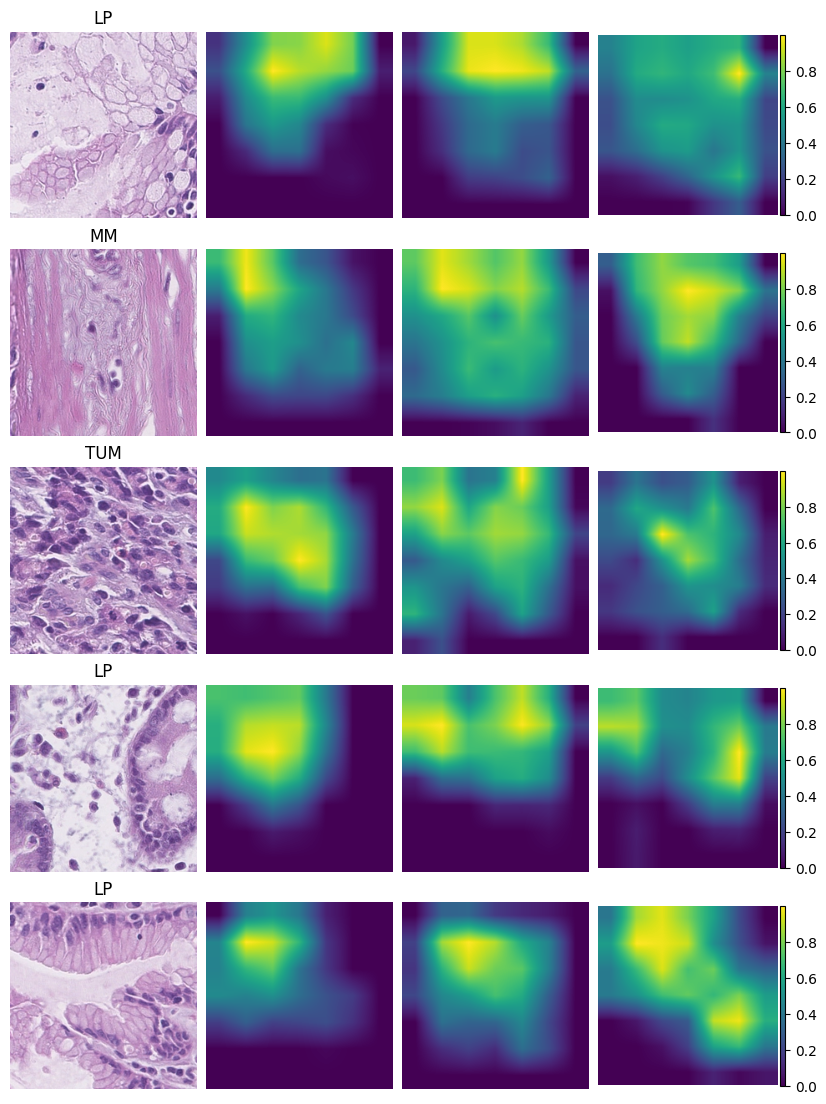

In [162]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
print(len(images))
fig, ax = plt.subplots(ncols=4, nrows=5, figsize = (10, 14))
fig.subplots_adjust(wspace=0.05, hspace=0.05)
#for i, (visualization_arr, image, label) in enumerate(zip(cum_visualization_arr[indices], images[indices], labels[indices])):
for i, ind in enumerate(indices):
    ax[i][0].axis("off")
    ax[i][1].axis("off")
    ax[i][0].set_title(classes_name[labels[ind]])
    ax[i][2].axis("off")
    ax[i][3].axis("off")
    ax[i][0].imshow(images[ind].permute(1, 2, 0))
    hm = ax[i][1].imshow(cum_grayscale_cam_arr[ind][0][0])
    hm = ax[i][2].imshow(cum_grayscale_cam_arr[ind][1][0])
    hm = ax[i][3].imshow(cum_grayscale_cam_arr[ind][2][0])
    divider = make_axes_locatable(ax[i][3])
    cax = divider.append_axes("right", size="3%", pad=0.02)
    
    plt.colorbar(hm, cax=cax)
plt.show()

tensor([0., 0., 1., 0., 0.])


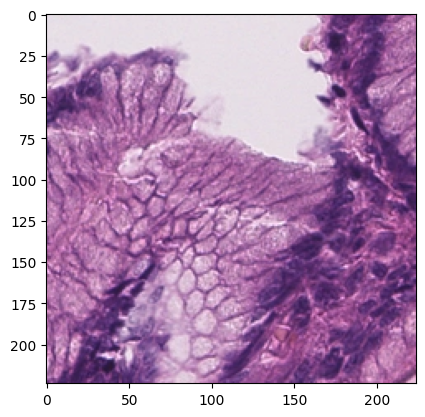

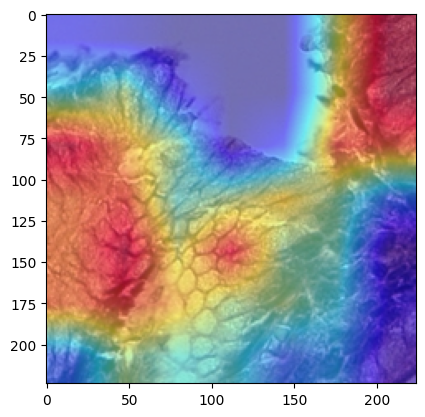

In [76]:
print(batch[1][1])
plt.imshow(visualization)
plt.show()